## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY



In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

%run MPPP.py
%matplotlib inline

In [20]:
file_extension = ''

'''
future work: save these calibration prameters as a text files, which we load for each camera
'''

# save images and thereby overwrite existing images
save_im    = 1

# add an alpha channel to the output images
save_mask  = 1

# add transparrent pixels to restore the image's full, standard size
pad_im     = 1
pad_im_z   = 1

# turn on when finding the waypoint offsets
find_offsets_mode = 0

# set the color values
gamma      = 2.2      # gamma value
gamma      = 2        # gamma value

# fraction of the dynamic range to clip off the lower values of image 
clip_low_z = 0.02  # for the Mastcam-Z cameras
clip_low   = 0.05  # for everything else


# scale all the scale parameters below bsy the same number
scale_scale = 18

# color balance parameters for the Mars 2020 science cameras
scale_z,  scale_red_z,  scale_blue_z  = [ 0.9*scale_scale, 0.7 , 1.5  ] # Mastcam-Z 
scale_l,  scale_red_l,  scale_blue_l  = [ 1.0*scale_scale, 0.75, 1.40 ] # SuperCam RMI
scale_s,  scale_red_s,  scale_blue_s  = [ 1.0*scale_scale, 0.85, 1.40 ] # SHERLOC WATSON 

# color balance parameters for the Mars 2020 engineering cameras
scale_n,  scale_red_n,  scale_blue_n  = [ 1.0*scale_scale, 0.75, 1.2  ] # Navcam
scale_f,  scale_red_f,  scale_blue_f  = [ 1.1*scale_scale, 0.78, 1.25 ] # Front Hazcam
scale_r,  scale_red_r,  scale_blue_r  = [ 1.1*scale_scale, 0.78, 1.25 ] # Rear Hazcam
scale_v,  scale_red_v,  scale_blue_v  = [ 1.1*scale_scale, 1.12, 0.92 ] # Grayscale VCE Navcam
scale_hr, scale_red_hr, scale_blue_hr = [ 1.0*scale_scale, 0.75, 1.43 ] # Inginuity RTE
scale_hn, scale_red_hn, scale_blue_hn = [ 1.0*scale_scale, 1.1 , 0.92 ] # Inginuity Navcam


In [21]:
# Set input path to IMG files and search criteria


# Set output directory
directory_output = 'Z:/Mastcam-Z/agisoft/images'
# directory_output = 'C:/Users/cornell/Desktop'
# directory_output = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/images' 

# Set input directory
directory_input = 'Z:/Mastcam-Z/agisoft/data'

pre = 'Z*0_067'
suf = 'refs_670s_zcam'

# pre = '*F_06'
# suf = 'refs_ecam_600s'

# pre = '*0_07'
# suf = 'refs_700s'

# directory_input = 'Z:/Mastcam-Z/agisoft/data/zcam'
# pre = 'Z*0_067*'
# suf = 'zcam_0670s'

# pre = 'S*F_068'
# suf = 'WATSON_sol680s'

# pre = 'Z*0_0'
# suf = 'zcam_refs'

sequ_id = ''

path_input      = directory_input
IMG_paths = [] \
        + sorted( glob.glob(  directory_input + '/datadrive/*/ids/rdr/*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) \
        + sorted( glob.glob(  directory_input + '/datadrive/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) \
        + sorted( glob.glob(  directory_input + '/zcam/sol*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 

print( len(IMG_paths), 'images\n')
IMG_paths

404 images



['Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA01.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA02.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA03.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA04.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726416242_785RAD_N0320580ZCAM03515_1100LMA01.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726416242_785RAD_N0320580ZCAM03515_1100LMA02.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726416242_785RAD_N0320580ZCAM03515_1100LMA03.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726416242_785RAD_N0320580ZCAM03515_1100LMA04.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\ZL0_0670_0726416335_785RAD_N0320580ZCAM03515_1100LMA01.IMG',
 'Z:/Mastcam-Z/agisoft/data/zcam\\sol_0600s\\Z

In [22]:
%%time

%run MPPP.py


pos_lines  = []
error_lines= []
rover_xyzs = []
im_xyzs    = []
rover_rots = []
im_azs     = []
im_els     = []
sols       = []
rmcs       = []
ims        = []
im_save_path = ''

print( len(IMG_paths), 'images\n')


for i in range(len(IMG_paths))[::][:]:
    
#     if 1:
    try:    # catch all the images that fail to process
        
        # open image
        im = image( IMG_paths[i] )
        print( i, im.filename )
        
        # Set color processing parameters
        im.scale       = scale_scale
        im.scale_red   = 1
        im.scale_blue  = 1
        im.clip_low    = clip_low
        im.gamma       = gamma
        im.pad_im      = pad_im
        im.save_im     = save_im
        im.save_mask   = save_mask
        im.find_offsets_mode = find_offsets_mode

        # Mars 2020 Mastcam-Z
        if im.cam[0] == 'Z':
            im.scale       = scale_z
            im.scale_red   = scale_red_z
            im.scale_blue  = scale_blue_z
            im.clip_low    = clip_low_z
            im.pad_im      = pad_im_z
            
            if 'IOF' in im.IMG_path:
                im.scale       = 2.0
                im.scale_red   = scale_red_z
                im.scale_blue  = scale_blue_z

        # Mars 2020 SHERLOC WATSON
        if im.cam[0] == 'S':
            im.scale       = scale_s
            im.scale_red   = scale_red_s
            im.scale_blue  = scale_blue_s
            im.clip_low    = 0.0

        # Mars 2020 SuperCam RMI
        if im.cam[0] == 'L':
            im.scale       = scale_l
            im.scale_red   = scale_red_l
            im.scale_blue  = scale_blue_l

        # Mars 2020 Navcam
        if im.cam[0] == 'N':
            im.scale       = scale_n
            im.scale_red   = scale_red_n
            im.scale_blue  = scale_blue_n

        # Mars 2020 Navcam VCE images
        if 'MV0' in im.IMG_path:
            im.scale       = scale_v
            im.scale_red   = scale_red_v
            im.scale_blue  = scale_blue_v
#             im.clip_low    = 0.15

        # Mars 2020 Front Hazcam
        if im.cam[0] == 'F':
            im.scale       = scale_f
            im.scale_red   = scale_red_f
            im.scale_blue  = scale_blue_f
            im.clip_low    = clip_low/2

        # Mars 2020 Rear Hazcam
        if im.cam[0] == 'R':
            im.scale       = scale_r
            im.scale_red   = scale_red_r
            im.scale_blue  = scale_blue_r
            im.clip_low    = clip_low/2

        # Heli Ingenuity RTE 
        if im.filename[0:3] == 'HSF':
            im.scale       = scale_hr
            im.scale_red   = scale_red_hr
            im.scale_blue  = scale_blue_hr

        # Heli Ingenuity Navcam  
        if im.filename[0:3] == 'HNM':
            im.scale       = scale_hn
            im.scale_red   = scale_red_hn
            im.scale_blue  = scale_blue_hn
        
        # create save directory
        im.save_path_full = make_save_path( im.IMG_path, directory_output, fullpath=True, file_extension = '.png'  ) 
        im.save_path      = make_save_path( im.IMG_path, directory_output, fullpath=False ) 
        im.save_name      = im.save_path_full.split('/')[-1]
        csv_save_path     = im.save_path
        
        # process and save image
        if im.save_im:
            
            im.image_process( )

            if im.save_mask:
                im.im8a = cv2.cvtColor( im.im8, cv2.COLOR_BGR2RGBA )
                im.im8a[:,:,3] = im.mask_im
                cv2.imwrite( im.save_path_full, im.im8a )                
            else:
                cv2.imwrite( im_save_path_full, im.im8[:,:,::-1] )  

        
        # find image position and rotation parameters
        im.image_reference( )

        # save reference data for plotting        
        '''
        future work: replace these lists with pandas dataframes
        '''
        im_xyzs   .append( [ im.X, im.Y, im.Z ] )
        rover_xyzs.append( [ im.X_offset, im.Y_offset, im.Z_offset ] )
        rover_rots.append( im.rot_rover )
        im_azs    .append( im.az )
        im_els    .append( im.el )
        rmcs      .append( im.label['ROVER_MOTION_COUNTER'])
        sols      .append( int(im.label['LOCAL_TRUE_SOLAR_TIME_SOL']) )
        
        # create a line for the reference file
        # Label	 X/East	Y/North	Z/Altitude	Yaw	Pitch	Roll
        pos_line =  im.save_name+'\t'\
                     +str( np.round( im.X,4))+'\t'\
                     +str( np.round( im.Y,4))+'\t'\
                     +str( np.round( im.Z,4))+'\t'\
                     +str( np.round( im.az,2))+'\t'\
                     +str( np.round( im.el,2))+'\t'\
                     +str( np.round( im.rl,2))+'\n'

        pos_lines.append( pos_line )

        try:
            print( 'sol {} site {} drive {}  zenith angle {:0.0f} scale {:0.2f}'.
                        format( im.sol, im.site, im.drive, im.el*57.3, im.ftau ) )
        except:
            print( 'sol {} site {} drive {}'.
                        format( im.sol, im.site, im.drive, ) )
        print( '', i, pos_line[:], )
        print( )

    except:
        print( im.filename, 'failed to process! \n' )
        error_lines.append( im.IMG_path +'\n' )


current_time = time.strftime("%Y%m%d-%H%M%S")


#save failed images list as TXT
if len(error_lines) > 0:
    csv_save_path = im.save_path+'/failed_'+suf+'_'+current_time+'.txt'
    with open(csv_save_path,'w') as file:
        for error_line in error_lines:
            file.write(error_line)

#save image positions as CSV file
csv_save_path = im.save_path+'/positions_'+suf+'_'+current_time+ '.txt'
with open(csv_save_path,'w') as file:
    for pos_line in pos_lines:
        file.write(pos_line)

len( pos_lines )

404 images

0 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA01.IMG
sol 670 site 32 drive 580  zenith angle 4825 scale 0.85
 0 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA01.png	-2400.9895	480.3509	26.6286	15.31	84.21	0


1 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA02.IMG
sol 670 site 32 drive 580  zenith angle 4825 scale 0.85
 1 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA02.png	-2400.9895	480.3509	26.6286	15.31	84.21	0


2 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA03.IMG
sol 670 site 32 drive 580  zenith angle 4825 scale 0.85
 2 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA03.png	-2400.9895	480.3509	26.6286	15.31	84.21	0


3 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA04.IMG
sol 670 site 32 drive 580  zenith angle 4825 scale 0.85
 3 ZL0_0670_0726415870_784RAD_N0320580ZCAM03515_1100LMA04.png	-2400.9895	480.3509	26.6286	15.31	84.21	0


4 ZL0_0670_0726416242_785RAD_N0320580ZCAM03515_1100LMA01.IMG
sol 670 site 32 drive 580  zenith a

36 ZL0_0670_0726425590_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 5406 scale 0.80
 36 ZL0_0670_0726425590_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9755	486.1706	26.626	154.38	94.35	0


37 ZL0_0670_0726425610_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 5403 scale 0.80
 37 ZL0_0670_0726425610_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9713	486.1339	26.626	171.16	94.29	0


38 ZL0_0670_0726425627_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4889 scale 0.80
 38 ZL0_0670_0726425627_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9706	486.1605	26.6211	154.55	85.33	0


39 ZL0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4886 scale 0.80
 39 ZL0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9695	486.1233	26.6211	171.15	85.27	0


40 ZL0_0670_0726425676_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith an

73 ZL0_0670_0726426233_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4280 scale 0.79
 73 ZL0_0670_0726426233_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1671	486.2512	26.6125	38.59	74.69	0


74 ZL0_0670_0726426248_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4282 scale 0.78
 74 ZL0_0670_0726426248_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1324	486.2661	26.6126	54.91	74.73	0


75 ZL0_0670_0726426263_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4284 scale 0.78
 75 ZL0_0670_0726426263_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.095	486.2707	26.6128	71.22	74.76	0


76 ZL0_0670_0726426278_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4284 scale 0.78
 76 ZL0_0670_0726426278_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.0578	486.2646	26.6129	87.52	74.77	0


77 ZL0_0670_0726426293_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle

110 ZL0_0670_0726426866_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 3052 scale 0.77
 110 ZL0_0670_0726426866_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9853	486.2213	26.5915	116.98	53.26	0


111 ZL0_0670_0726426881_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 3050 scale 0.77
 111 ZL0_0670_0726426881_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9645	486.1808	26.5916	135.62	53.22	0


112 ZL0_0670_0726426898_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 3047 scale 0.76
 112 ZL0_0670_0726426898_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9577	486.1359	26.5916	154.28	53.17	0


113 ZL0_0670_0726426911_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 2427 scale 0.76
 113 ZL0_0670_0726426911_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.0671	486.2772	26.5782	74.36	42.35	0


114 ZL0_0670_0726426954_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672 

sol 676 site 32 drive 774  zenith angle 3255 scale 0.89
 145 ZL0_0676_0726952366_598RAD_N0320774ZCAM03517_1100LMA01.png	-2393.1044	481.2087	26.4238	3.1	56.8	0


146 ZL0_0676_0726952442_598RAD_N0320774ZCAM03517_1100LMA01.IMG
sol 676 site 32 drive 774  zenith angle 3255 scale 0.89
 146 ZL0_0676_0726952442_598RAD_N0320774ZCAM03517_1100LMA01.png	-2393.1044	481.2087	26.4238	3.1	56.8	0


147 ZL0_0676_0726952696_081RAD_N0320774ZCAM03014_048085A01.IMG
resizing image size (688, 624, 3) by padding = [ left, right, top, bottom ] = [ 1024, 0, 0, 512 ]
sol 676 site 32 drive 774  zenith angle 3158 scale 0.89
 147 ZL0_0676_0726952696_081RAD_N0320774ZCAM03014_048085A01.png	-2392.8721	481.2285	26.4277	122.67	55.11	0


148 ZL0_0676_0726952761_738RAD_N0320774ZCAM03518_1100LMA01.IMG
sol 676 site 32 drive 774  zenith angle 5282 scale 0.89
 148 ZL0_0676_0726952761_738RAD_N0320774ZCAM03518_1100LMA01.png	-2393.0934	481.2071	26.4478	20.62	92.19	0


149 ZL0_0676_0726953139_738RAD_N0320774ZCAM03518_1100LMA01.IMG

sol 678 site 32 drive 774  zenith angle 2212 scale 0.88
 180 ZL0_0678_0727127904_660RAD_N0320774ZCAM08673_1100LMA01.png	-2393.1176	481.1161	26.4054	-39.59	38.6	0


181 ZL0_0678_0727143168_473RAD_N0320896ZCAM01025_034050A01.IMG
resizing image size (1200, 1600, 3) by padding = [ left, right, top, bottom ] = [ 32, 16, 0, 0 ]
sol 678 site 32 drive 896  zenith angle 8924 scale 0.50
 181 ZL0_0678_0727143168_473RAD_N0320896ZCAM01025_034050A01.png	-2381.7479	496.9906	26.7796	-95.69	155.74	0


182 ZL0_0678_0727143235_473RAD_N0320896ZCAM01025_034050A01.IMG
resizing image size (1200, 1600, 3) by padding = [ left, right, top, bottom ] = [ 32, 16, 0, 0 ]
sol 678 site 32 drive 896  zenith angle 6125 scale 0.50
 182 ZL0_0678_0727143235_473RAD_N0320896ZCAM01025_034050A01.png	-2381.7058	497.1676	26.7944	146.32	106.9	0


183 ZL0_0678_0727143416_473RAD_N0320896ZCAM01025_034050A01.IMG
resizing image size (1200, 1600, 3) by padding = [ left, right, top, bottom ] = [ 32, 16, 0, 0 ]
sol 678 site 32 drive 896

214 ZR0_0670_0726425330_738RAD_N0320672ZCAM08667_0340LMA02.IMG
sol 670 site 32 drive 672  zenith angle 5400 scale 0.81
 214 ZR0_0670_0726425330_738RAD_N0320672ZCAM08667_0340LMA02.png	-2397.1767	486.2329	26.626	-116.83	94.24	0


215 ZR0_0670_0726425348_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 5399 scale 0.81
 215 ZR0_0670_0726425348_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1459	486.2517	26.6261	-100.03	94.23	0


216 ZR0_0670_0726425348_738RAD_N0320672ZCAM08667_0340LMA02.IMG
sol 670 site 32 drive 672  zenith angle 5399 scale 0.81
 216 ZR0_0670_0726425348_738RAD_N0320672ZCAM08667_0340LMA02.png	-2397.1459	486.2517	26.6261	-100.03	94.23	0


217 ZR0_0670_0726425363_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 5399 scale 0.81
 217 ZR0_0670_0726425363_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1109	486.2607	26.6262	-83.23	94.22	0


218 ZR0_0670_0726425363_738RAD_N0320672ZCAM08667_0340LMA02.IMG
sol 670 site 32 drive 6

sol 670 site 32 drive 672  zenith angle 4900 scale 0.80
 250 ZR0_0670_0726425627_738RAD_N0320672ZCAM08667_0340LMA02.png	-2397.187	486.0487	26.6204	152.21	85.51	0


251 ZR0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4896 scale 0.80
 251 ZR0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.2088	486.0779	26.6203	168.81	85.45	0


252 ZR0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA02.IMG
sol 670 site 32 drive 672  zenith angle 4896 scale 0.80
 252 ZR0_0670_0726425659_738RAD_N0320672ZCAM08667_0340LMA02.png	-2397.2088	486.0779	26.6203	168.81	85.45	0


253 ZR0_0670_0726425676_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4902 scale 0.80
 253 ZR0_0670_0726425676_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1578	486.0269	26.6205	135.61	85.55	0


254 ZR0_0670_0726425676_738RAD_N0320672ZCAM08667_0340LMA02.IMG
sol 670 site 32 drive 672  zenith angle 4902 scale 0.80
 254 ZR0_0670_0726425676_738RAD_N

287 ZR0_0670_0726426263_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4294 scale 0.78
 287 ZR0_0670_0726426263_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.0095	486.0427	26.6126	68.81	74.93	0


288 ZR0_0670_0726426278_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4294 scale 0.78
 288 ZR0_0670_0726426278_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.0398	486.0218	26.6125	85.11	74.95	0


289 ZR0_0670_0726426293_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4294 scale 0.78
 289 ZR0_0670_0726426293_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.0747	486.0102	26.6123	101.39	74.95	0


290 ZR0_0670_0726426308_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 4293 scale 0.78
 290 ZR0_0670_0726426308_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1115	486.0088	26.6122	117.68	74.93	0


291 ZR0_0670_0726426323_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  

sol 670 site 32 drive 672  zenith angle 3058 scale 0.76
 323 ZR0_0670_0726426898_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1741	486.0246	26.5901	151.4	53.37	0


324 ZR0_0670_0726426911_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 2438 scale 0.76
 324 ZR0_0670_0726426911_738RAD_N0320672ZCAM08667_0340LMA01.png	-2396.9937	486.0452	26.5773	70.93	42.54	0


325 ZR0_0670_0726426954_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 2431 scale 0.76
 325 ZR0_0670_0726426954_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.1717	486.0199	26.5767	151.05	42.43	0


326 ZR0_0670_0726426982_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 2436 scale 0.76
 326 ZR0_0670_0726426982_738RAD_N0320672ZCAM08667_0340LMA01.png	-2397.13	486.0024	26.5768	132.4	42.51	0


327 ZR0_0670_0726426995_738RAD_N0320672ZCAM08667_0340LMA01.IMG
sol 670 site 32 drive 672  zenith angle 2438 scale 0.76
 327 ZR0_0670_0726426995_738RAD_N0320

359 ZR0_0676_0726952290_081RAD_N0320774ZCAM08675_1100LMA02.IMG
sol 676 site 32 drive 774  zenith angle 4389 scale 0.89
 359 ZR0_0676_0726952290_081RAD_N0320774ZCAM08675_1100LMA02.png	-2393.0435	481.2592	26.4414	-103.29	76.6	0


360 ZR0_0676_0726952348_639RAD_N0320774ZCAM03517_1100LMA01.IMG
resizing image size (128, 128, 3) by padding = [ left, right, top, bottom ] = [ 400, 1120, 448, 624 ]
sol 676 site 32 drive 774  zenith angle 3262 scale 0.89
 360 ZR0_0676_0726952348_639RAD_N0320774ZCAM03517_1100LMA01.png	-2392.8609	481.2044	26.426	0.3	56.93	0


361 ZR0_0676_0726952366_598RAD_N0320774ZCAM03517_1100LMA01.IMG
resizing image size (128, 128, 3) by padding = [ left, right, top, bottom ] = [ 400, 1120, 448, 624 ]
sol 676 site 32 drive 774  zenith angle 3262 scale 0.89
 361 ZR0_0676_0726952366_598RAD_N0320774ZCAM03517_1100LMA01.png	-2392.8609	481.2044	26.426	0.3	56.93	0


362 ZR0_0676_0726952502_598RAD_N0320774ZCAM03517_1100LMA01.IMG
sol 676 site 32 drive 774  zenith angle 3261 scale 0.89
 

394 ZR0_0677_0727044734_069RAD_N0320774ZCAM03014_048085A01.IMG
resizing image size (688, 624, 3) by padding = [ left, right, top, bottom ] = [ 0, 1024, 0, 512 ]
sol 677 site 32 drive 774  zenith angle 3169 scale 0.86
 394 ZR0_0677_0727044734_069RAD_N0320774ZCAM03014_048085A01.png	-2392.9974	481.019	26.4247	119.84	55.3	0


395 ZR0_0677_0727044807_473RAD_N0320774ZCAM03522_1100LMA01.IMG
sol 677 site 32 drive 774  zenith angle 4039 scale 0.85
 395 ZR0_0677_0727044807_473RAD_N0320774ZCAM03522_1100LMA01.png	-2392.8853	481.0658	26.4371	60.99	70.48	0


396 ZR0_0677_0727053084_848RAD_N0320774ZCAM08673_1100LMA01.IMG
sol 677 site 32 drive 774  zenith angle 2219 scale 0.57
 396 ZR0_0677_0727053084_848RAD_N0320774ZCAM08673_1100LMA01.png	-2392.9377	481.2801	26.4063	-43.35	38.73	0


397 ZR0_0678_0727127904_660RAD_N0320774ZCAM08673_1100LMA01.IMG
sol 678 site 32 drive 774  zenith angle 2219 scale 0.88
 397 ZR0_0678_0727127904_660RAD_N0320774ZCAM08673_1100LMA01.png	-2392.9377	481.2801	26.4063	-43.34	38.

404

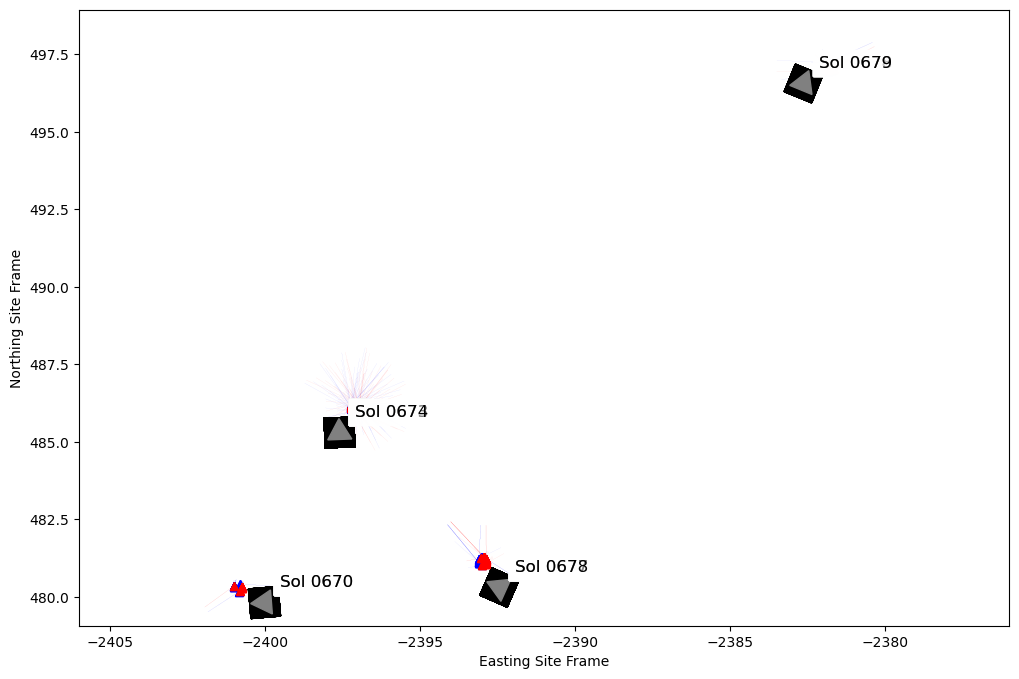

In [23]:
%run MPPP.py

# plot image and rover locations

plot_image_locations( IMG_paths, im_xyzs, rover_xyzs, rover_rots, im_azs, im_els )

## Ignore the notes below

In [7]:
# '''
# df_refs : pandas dataframe that holds reference info for each image

# data saves in the output directory as a CSV file 'df'+output+'.csv' and as a python pickle 'df'+output+'.pkl'

# '''

# df_refs = pd.DataFrame( 
#     columns = [ 
#         'sol',           # sol number or Mars day since landing is a natural way to describe images.
#         'site',          # site index for the rover's location, site 3 is the landing site
#         'drive',         # drive index is where the rover is relative to the current site frame
#         'time',          # datetime of image capture
        
#         'xyz_enu',       # postition XYZ values in meters ENU = [xEast, yNorth, zUp ] from site 3 (note: as Metashape interprets XYZ)
#         'xyz_ned',       # postition XYZ values in meters NED = [xNorth, yEast, zDown] from site 3
#         'rot_rpy',       # rotation angles in RPY = [roll, pitch, yaw] in degrees (as Metashape interprets roll-pitch-yaw)
#         'rot_ypr',       # rotation angles in YPR = [yaw, pitch, roll] in degrees 
#         'rot_opk',       # rotation angles in OPK = [omega, phi, kappa] in degrees 
        
#         'site_wy',       # waypoint site index, same as the current site if 'site_wy' == 'site' 
#         'drive_wp',      # waypoint drive index, same as the current drive if 'drive_wy' == 'drive'      
#         'xyz_wp',        # waypoint postition XYZ values in meters NED = [xNorthing, yEasting, zElevation]
#         'xyz_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorth, yEast, zDown], 'xyz_site3'=[0,0,0] if site3 is the default reference frame
#         'nee_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorthing, yEasting, zElevation]
#         'lle_site3'      # postition in [longitude, latitude, elevation] Mars global coordinates        
       
#         'cahvor',        # the CAHVOR or CAHVORE camera model in rover frame [xFront, yRight, zDown]
#         'az_site',       # site-frame azimuth pointing in degrees clockwise from the North vector 
#         'el_site',       # site-frame elevation pointing in degrees positive from the horizone
#         'az_rover',      # rover-frame azimuth pointing in degrees clockwise from the rover's forward vector
#         'el_rover',      # rover-frame elevation pointing in degrees positive from the forward-right plane       
        
#         'ref',           # string that forms the image's line in the reference file for import to software (Metashape)
#         'filename',      # file name with .IMG extension
#         'filepath',      # complete file path to image at run time
# ])


# df_refs

In [8]:
# ignore the below cells

In [9]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

In [10]:
# Scam flatfield

path = 'C:/Users/cornell/Mastcam-Z/ws/seitah'
pre = 'L*_0510*'

RAD_paths = [] \
          + sorted( glob.glob(  path + '/' +pre+'*R*_N*.IMG' ) ) \

RAD_paths

ims = []
for i in range(len(RAD_paths))[:]:
    
    im_image = PDS3Image.open( RAD_paths[i] ).image
    ims.append( np.float64( im_image) )
    
flat = np.mean( ims, axis=0)
for i in range(3):
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
    
plt.imshow( flat/1.5 )

C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

In [ ]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)
xv, yv = np.meshgrid(x, y)

y0, x0, r0, p = [900,1000,1000,3]
dv = ( (xv-x0)**2 + (yv-y0)**2 )**(p/2)
dv /= (r0**p)*2
dv += 1

# lim = .8
# dv[ dv<lim]  =lim

dflat = flat.copy()
for i in range(3):
    dflat[:,:,i] *= dv
    
plt.imshow( dflat/2 )
plt.colorbar()

In [ ]:
dvl = np.mean( dflat[:,1000:1300], axis=1)
plt.plot(dvl)

dvl = np.mean( flat[:,1000:1300], axis=1)
plt.plot(dvl)
# flat = dflat.copy()

In [ ]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           ''+'\t',''+'\t',''+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )